## Backtesting Crypto Strategies to be implemented in GoLang

### Environment:

Data Loader: Gets OHLCV data (you can use yfinance, ccxt, or CSVs)

Signal Generator (Strategy): Returns a DataFrame of portfolio weights

Backtester: Calculates portfolio value over time

Evaluator: Computes metrics like Sharpe ratio, drawdown, turnover

Visualizer: Plots equity curve and stats

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import ccxt
import time


## Data Loader:

In [2]:

def fetch_full_hourly_ohlcv(symbol, start_date='2023-01-01T00:00:00Z'):
    exchange = ccxt.binance()
    market = symbol + '/USDT'
    timeframe = '1h'
    limit = 1000
    all_data = []

    # Converts the human-readable date to a millisecond timestamp.
    since = exchange.parse8601(pd.to_datetime(start_date).isoformat())
 

    while True:
        print(f"Fetching {symbol} since {pd.to_datetime(since, unit='ms')}")
        data = exchange.fetch_ohlcv(market, timeframe=timeframe, since=since, limit=limit)
        if not data:
            break
        all_data.extend(data)
        since = data[-1][0] + 1  # Move past the last fetched timestamp
        time.sleep(1.2)  # Respect Binance rate limits

        # Optional: stop once we're beyond current time
        if pd.to_datetime(data[-1][0], unit='ms') >= pd.Timestamp.now():
            break

    df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('date', inplace=True)
    return df[['close']]

def load_hourly_prices(symbols, start_date='2023-01-01T00:00:00Z'):
    all_data = []
    for symbol in symbols:
        try:
            print(f"\nLoading {symbol}...")
            df = fetch_full_hourly_ohlcv(symbol, start_date)
            df.rename(columns={'close': symbol}, inplace=True)
            all_data.append(df)
        except Exception as e:
            print(f"Failed to fetch {symbol}: {e}")
        time.sleep(1.5)
    
    price_df = pd.concat(all_data, axis=1).ffill().dropna()
    price_df.to_csv("hourly_crypto_prices.csv")
    print("\nSaved to hourly_crypto_prices.csv ✅")
    return price_df


In [4]:
# Fetch data and save to CSV
symbols = ['BTC', 'ETH', 'SOL', 'BNB', 'XRP']
prices = load_hourly_prices(symbols, start_date='2023-05-01T00:00:00Z')
prices.head()


Loading BTC...
Fetching BTC since 2023-05-01 00:00:00
Fetching BTC since 2023-06-11 15:00:00.001000
Fetching BTC since 2023-07-23 07:00:00.001000
Fetching BTC since 2023-09-02 23:00:00.001000
Fetching BTC since 2023-10-14 15:00:00.001000
Fetching BTC since 2023-11-25 07:00:00.001000
Fetching BTC since 2024-01-05 23:00:00.001000
Fetching BTC since 2024-02-16 15:00:00.001000
Fetching BTC since 2024-03-29 07:00:00.001000
Fetching BTC since 2024-05-09 23:00:00.001000
Fetching BTC since 2024-06-20 15:00:00.001000
Fetching BTC since 2024-08-01 07:00:00.001000
Fetching BTC since 2024-09-11 23:00:00.001000
Fetching BTC since 2024-10-23 15:00:00.001000
Fetching BTC since 2024-12-04 07:00:00.001000
Fetching BTC since 2025-01-14 23:00:00.001000
Fetching BTC since 2025-02-25 15:00:00.001000
Fetching BTC since 2025-04-08 07:00:00.001000
Fetching BTC since 2025-05-19 23:00:00.001000
Fetching BTC since 2025-05-27 08:00:00.001000

Loading ETH...
Fetching ETH since 2023-05-01 00:00:00
Fetching ETH sin

,BTC,ETH,SOL,BNB,XRP
date,,,,,
2023-05-01 00:00:00,29315.57,1885.33,22.84,338.8,0.4711
2023-05-01 01:00:00,28504.36,1836.00,22.19,333.4,0.4633
2023-05-01 02:00:00,28549.41,1843.87,22.20,333.7,0.4606
2023-05-01 03:00:00,28561.06,1846.58,22.18,334.5,0.4648
2023-05-01 04:00:00,28555.00,1847.67,22.17,334.5,0.4653


## Signal Generation:

In [31]:
# Equal Weight Strategy:
def equal_weight_strategy(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Generate an equal-weighted signal for all available tokens at each timestamp.
    
    Parameters:
        prices : DF of token prices with datetime index and token symbols as columns.
    
    Returns:
        DF: Equal-weight portfolio weights over time.
    """
    
    num_assets = prices.shape[1]
    equal_weights = pd.DataFrame(
        1 / num_assets,
        index=prices.index,
        columns=prices.columns
    )
    return equal_weights

In [32]:
# Momentum Strategy:
def momentum_strategy(prices: pd.DataFrame, lookback_hours: int = 24, top_n: int = 3, lag: int = 1) -> pd.DataFrame:
    """
    Generate a momentum-based signal: long top N assets by past return over lookback period.

    Parameters:
        prices : pd.DataFrame
            Price data (Date x Assets)
        lookback_hours : int
            Lookback window for momentum signal (in hours)
        top_n : int
            Number of top-performing assets to long at each time step

    Returns:
        pd.DataFrame: Portfolio weights over time (Date x Assets)
    """
    # Calculate past returns over lookback
    past_prices = prices.shift(lag)
    momentum_scores = past_prices.pct_change(lookback_hours)

    # Rank assets by momentum
    ranks = momentum_scores.rank(axis=1, ascending=False)

    # Select top N assets
    signals = (ranks <= top_n).astype(float)

    # Normalize weights to 1 for selected assets
    weights = signals.div(signals.sum(axis=1), axis=0).fillna(0)

    return weights

In [49]:
def momentum_strategy_optimized(prices: pd.DataFrame, lookback_hours: int = 672, top_n: int = 3, hold_period: int = 120, lag: int = 1) -> pd.DataFrame:
    """
    Momentum strategy with 28-day lookback and 5-day holding period.

    Parameters:
        prices : pd.DataFrame
            Hourly price data (Date x Tokens)
        lookback_hours : int
            Lookback window for momentum signal (default 28 days = 672 hours)
        top_n : int
            Number of top assets to long
        hold_period : int
            Number of hours to hold each position (default 5 days = 120 hours)
        lag : int
            Lag in hours to prevent look-ahead bias (default = 1)

    Returns:
        pd.DataFrame: Weights over time (Date x Tokens)
    """
    # Calculate past returns using lagged prices to prevent look-ahead
    past_prices = prices.shift(lag)
    momentum_scores = past_prices.pct_change(lookback_hours)

    # Rank assets
    ranks = momentum_scores.rank(axis=1, ascending=False)
    signals = (ranks <= top_n).astype(float)
    weights_raw = signals.div(signals.sum(axis=1), axis=0).fillna(0)

    # Apply holding period: only update every `hold_period` hours
    weights = weights_raw.copy()
    last_valid = None

    for i in range(len(weights)):
        if i % hold_period == 0:
            last_valid = weights.iloc[i]
        else:
            weights.iloc[i] = last_valid

    return weights


In [48]:
# Implement equal weight strategy:
prices = pd.read_csv("hourly_crypto_prices.csv", index_col=0, parse_dates=True)

weights_mom = momentum_strategy(prices, lookback_hours=24, top_n=3, lag=1)


## Backtest

In [41]:
# Backtest:

def compute_log_returns(prices: pd.DataFrame) -> pd.DataFrame:
    return np.log(prices / prices.shift(1)).fillna(0)

def backtest_portfolio(prices: pd.DataFrame, weights: pd.DataFrame, transaction_fee: float = 0.0):
    """
    Backtest any portfolio weight strategy with optional transaction costs.

    Parameters:
        prices (pd.DataFrame): Price data (Date x Assets).
        weights (pd.DataFrame): Portfolio weights (Date x Assets).
        transaction_fee (float): Cost per unit traded (e.g., 0.001 = 0.10%).

    Returns:
        portfolio_log_returns (pd.Series): Strategy log returns (after cost).
        cumulative_returns (pd.Series): Cumulative portfolio value over time.
        turnover_series (pd.Series): Portfolio turnover at each step.
    """
    log_returns = compute_log_returns(prices)
    shifted_weights = weights.shift(1).fillna(0)

    # Calculate raw log returns from portfolio
    raw_log_returns = (shifted_weights * log_returns).sum(axis=1)

    # Compute turnover (sum of absolute changes in weights)
    turnover = (weights - shifted_weights).abs().sum(axis=1)

    # Compute cost = turnover × transaction_fee
    cost = turnover * transaction_fee

    # Subtract transaction cost from log returns
    net_log_returns = raw_log_returns - cost

    cumulative_returns = np.exp(net_log_returns.cumsum())
    return net_log_returns, cumulative_returns, turnover



## Evaluate:

In [55]:
def evaluate_performance(portfolio_log_returns: pd.Series):
    mean_ret = portfolio_log_returns.mean()
    std_ret = portfolio_log_returns.std()
    
    # Annualized Sharpe for hourly returns (~8760 trading hours/year)
    sharpe_ratio = (mean_ret / std_ret) * np.sqrt(8760)

    cumulative_returns = np.exp(portfolio_log_returns.cumsum())
    running_max = cumulative_returns.cummax()
    drawdown = 1 - (cumulative_returns / running_max)

    max_dd = drawdown.max()
    end_date = drawdown.idxmax()
    start_date = cumulative_returns[:end_date].idxmax()

    return {
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_dd,
        "Max Drawdown Start": start_date,
        "Max Drawdown End": end_date,
        "Total Return": cumulative_returns.iloc[-1] - 1
    }

def print_metrics(metrics: dict, title: str = "Performance Metrics"):
    """
    Print performance metrics with smart formatting.

    Parameters:
        metrics (dict): Dictionary of metric names and values.
        title (str): Optional title to display above the metrics.
    """
    print(f"\n{title}:")
    for k, v in metrics.items():
        if isinstance(v, (int, float)):
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")


In [56]:
# Evaluate metrics:

portfolio_log_returns_mom, cumulative_returns_mom, turnover_mom = backtest_portfolio(prices, weights_mom, transaction_fee=0.001)
metrics_mom = evaluate_performance(portfolio_log_returns_mom)

print_metrics(metrics_mom, title="Momentum Strategy Performance")


Momentum Strategy Performance:
Sharpe Ratio: -1.0665
Max Drawdown: 0.7663
Max Drawdown Start: 2023-05-06 00:00:00
Max Drawdown End: 2025-04-07 06:00:00
Total Return: -0.7392


In [53]:
weights_opt_mom = momentum_strategy_optimized(prices)

log_ret_opt_mom, cum_ret_opt_mom, turnover_opt_mom = backtest_portfolio(prices, weights_opt_mom, transaction_fee=0.001)

metrics = evaluate_performance(log_ret_opt_mom)

## Visualize:

In [44]:
def plot_equity_curves(cumulative_returns_dict: dict):
    """
    Plot multiple cumulative return series on the same equity curve chart.

    Parameters:
        cumulative_returns_dict (dict): A dictionary where keys are labels (e.g., strategy names)
                                        and values are pd.Series of cumulative returns.
    """
    plt.figure(figsize=(12, 6))
    
    for label, curve in cumulative_returns_dict.items():
        plt.plot(curve, label=label)
    
    plt.title("Equity Curves Comparison")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.legend()
    plt.show()


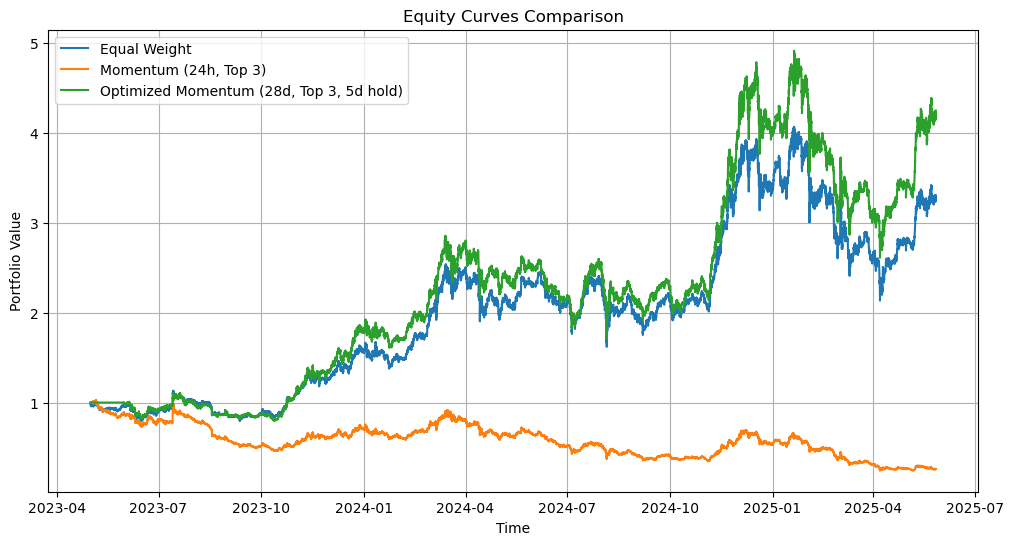

In [54]:
# Visualization

equal_weights = equal_weight_strategy(prices)
_, cum_eq, _ = backtest_portfolio(prices, equal_weights, transaction_fee=0.001)


plot_equity_curves({
    "Equal Weight": cum_eq,
    "Momentum (24h, Top 3)": cumulative_returns_mom,
    "Optimized Momentum (28d, Top 3, 5d hold)": cum_ret_opt_mom
})
